# IT Tickets Classification Project

## Previous Notebooks

- [Data Collection](0-Data Collection.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
%matplotlib inline

In this notebook I will clean the data I got from the JIRA REST API and create a word of bag using ticket's summary and description. I will also do some EDA to find the right target variable.

## Data Cleaning

In [2]:
issues = pd.read_pickle('../data/raw/issues.pkl')

In [3]:
issues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20178 entries, 0 to 20177
Data columns (total 9 columns):
key              20178 non-null object
creation_date    20178 non-null object
creator          20178 non-null object
description      20178 non-null object
issue_type       20178 non-null object
reporter         20178 non-null object
summary          20178 non-null object
solution         20092 non-null object
rel_issue        20178 non-null object
dtypes: object(9)
memory usage: 1.4+ MB


First of all I'm going to convert the creation date to datetime and to select the first element of the list in the rel_issue column, which contains the related tickets that were created to manage the request.

In [4]:
issues['creation_date'] = pd.to_datetime(issues['creation_date'])

In [5]:
issues['rel_issue'] = issues['rel_issue'].apply(lambda x: x[0] if x != [] else np.nan)

Then I'm appending the text in the summary to that in the description, cleaning it from new lines, and I'm using regex expressions to delete web and network addresses, emails,dates and all the words containing both numbers and letters (which usually are ids used to identify users or other entities).

In [6]:
issues['text'] = issues['summary'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' ')) + ' ' + issues['description'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

In [7]:
# http addresses
issues['text'] = issues['text'].apply(lambda x: re.sub(r'http(s)*:[^\s]*', '', x))

In [8]:
# emails
issues['text'] = issues['text'].apply(lambda x: re.sub(r'[^\s]*@[^\s]*', '', x))

In [9]:
# network addresses
issues['text'] = issues['text'].apply(lambda x: re.sub(r'[^\s]*\\[^\s]*', '', x))

In [10]:
# dates
issues['text'] = issues['text'].apply(lambda x: re.sub(r'\d+([\/|.]\d+)+', '', x))

In [11]:
# digits or // with zero or more letters or special characters around
issues['text'] = issues['text'].apply(lambda x: re.sub(r'(\w*|[^a-zA-Z\s]*)[\d|\+|(\/){2}]+(\w*|[^a-zA-Z\s]*)', '', x))

Since I have a lot of personal nouns I have collected all the capitalized words and analyzed them in order to create a list of terms to exclude from the analysis.

In [12]:
capitalized = []
for text in issues['text']:
    capitalized = capitalized + re.findall('([A-Z][a-z]+|[a-z][A-Z]+)', text)

In [13]:
pd.Series(list(set(capitalized))).to_csv('../data/raw/capitalized.csv')

In [14]:
my_stop_words = pd.read_csv('../data/raw/stop.csv', sep=';')

In [15]:
issues['text'] = issues['text'].str.lower()

Finally I'm creating a bag of words from the text columns, eliminating italian stop words and stemming the remaining terms.

In [16]:
r = re.compile(r'\w')
issues['bag_of_words'] = issues['text'].apply(lambda x: list(filter(r.match, wordpunct_tokenize(x))))

In [17]:
itst = ItalianStemmer()
sw = stopwords.words('italian')
sw = set(sw).union(set(list(my_stop_words['word'].values)))
issues['bag_of_words'] = issues['bag_of_words'].apply(lambda x: [itst.stem(w) for w in x if w not in sw and len(w) > 2])

In [18]:
issues['bag_of_words'] = issues['bag_of_words'].apply(lambda x: pd.Series(x).value_counts().to_dict())

## EDA

Now I want to briefly analyze my target variable candidate:
- `rel_issue`, which is the related ticket opened to the workgroup which has to resolve the issue
- `solution`, which is a brief description of how the issue has been handled

I have a lot of values in the `rel_issue` because the columns contains the ticket id; this is in the form `WORKGROUP-NUMBER`, so I'm going to keep only the first part of it. I'm also assigning all the missing values to the ISAHD group, because these are the issues that were not channeled toward another workgroup.

In [19]:
print(len(issues['rel_issue'].unique()))
issues['rel_issue'].unique()[0:5]

1984


array([nan, 'ISAITAMS-12418', 'ISAITAMS-12417', 'ISAITAMS-12413',
       'ISAITAMS-12414'], dtype=object)

In [20]:
issues['rel_issue'] = issues['rel_issue'].apply(lambda x: re.sub(r'-\d+$', '', str(x)))
issues['rel_issue'] = issues['rel_issue'].str.replace('nan', 'ISAHD')

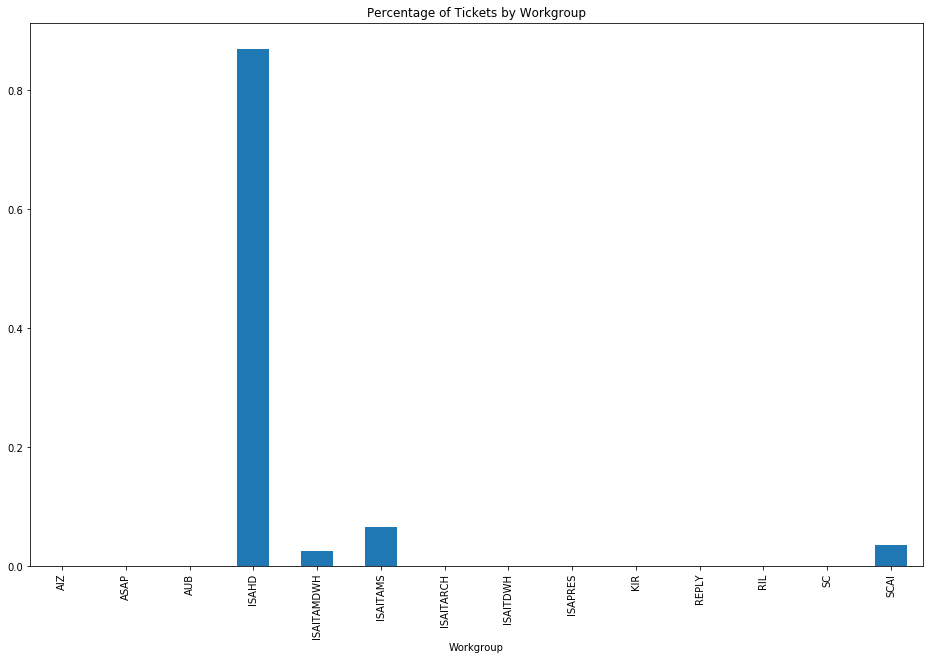

In [21]:
(issues.groupby(['rel_issue'])['key'].count() / len(issues)).plot.bar(figsize=(16, 10))
plt.title('Percentage of Tickets by Workgroup')
plt.xlabel('Workgroup');
# plt.savefig('../reports/figures/workgroup.png');

The number of ticket is very unbalanced among workgroups, so I'm going to group some of them in one category.

In [22]:
issues['label'] = issues['rel_issue'].apply(lambda x: x if x in ('ISAHD', 'ISAITAMDWH', 'ISAITAMS', 'SCAI') else 'OTHER')

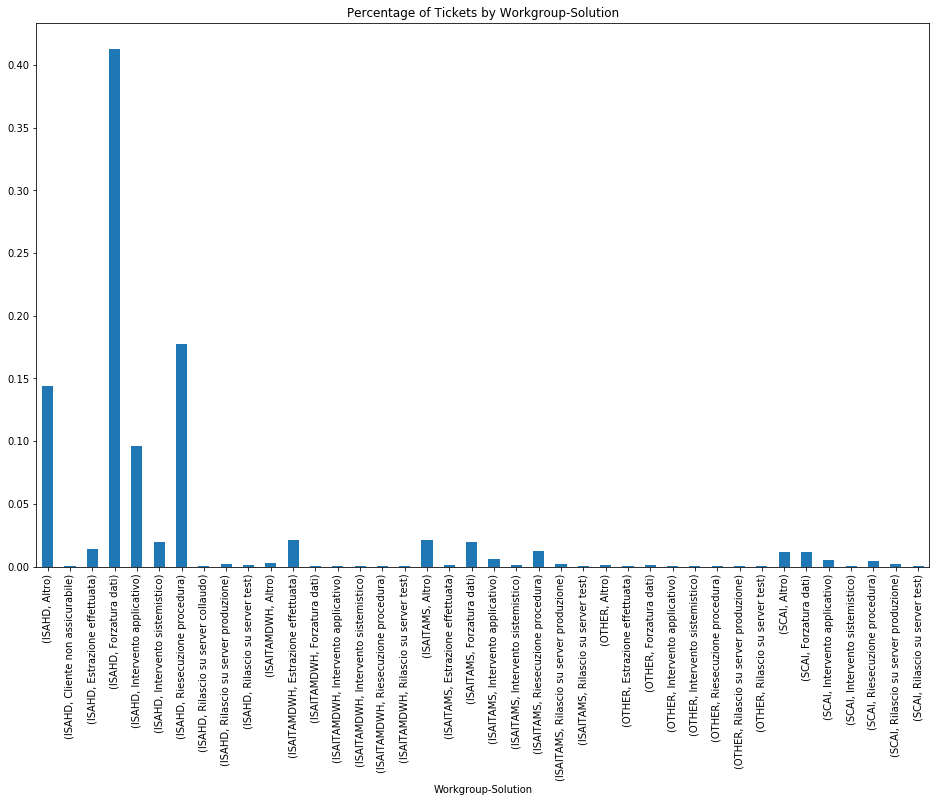

In [23]:
(issues.groupby(['label', 'solution'])['key'].count() / len(issues)).plot.bar(figsize=(16, 10))
plt.title('Percentage of Tickets by Workgroup-Solution')
plt.xlabel('Workgroup-Solution');
# plt.savefig('../reports/figures/workgroup_solution.png');

Since the ISAHD group is the one with the greater number of tickets, I will use the solution to distinguish among them: this makes sense also because this group is the one charged with choosing how to channel an issue, so it could be useful to give them the possibility to know whether an issue has to be forwarded to another group or, in case they need to solve the issue themselves, what type of resolution it is requested.

In [24]:
issues['label'] = issues.apply(lambda x: 
                               x['label'] if x['label'] in ('ISAITAMDWH', 'OTHER', 'SCAI', 'ISAITAMS')
                               else x['label'] + ' Altro' if x['solution']=='Cliente non assicurabile'
                               else x['label'] + ' Intervento' if x['solution'] in ('Intervento applicativo', 'Intervento sistemistico')
                               else x['label'] + ' Rilascio' if x['solution'] in ('Rilascio su server collaudo', 'Rilascio su server produzione', 'Rilascio su server test')
                               else x['label'] + ' Altro' if pd.isnull(x['solution'])
                               else x['label'] + ' ' + x['solution']
                              , axis=1)

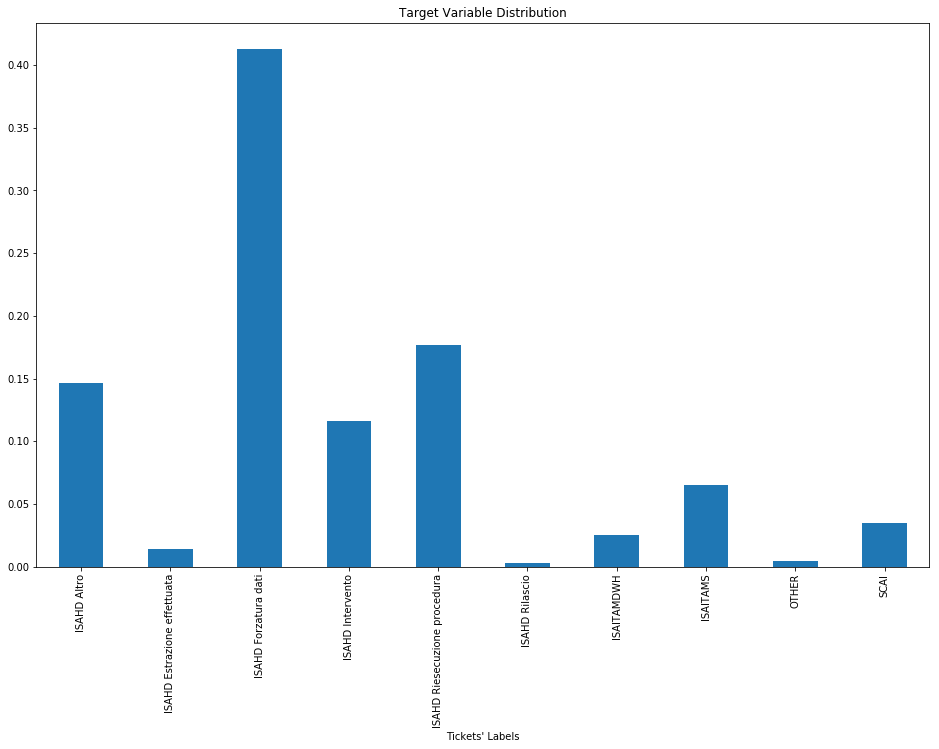

In [25]:
(issues.groupby(['label'])['key'].count() / len(issues)).plot.bar(figsize=(16, 10))
plt.title('Target Variable Distribution')
plt.xlabel('Tickets\' Labels');
# plt.savefig('../reports/figures/label.png');

In [26]:
issues.to_pickle('../data/interim/bag_of_words.pkl')

## Following Notebooks

- [Document-Term Matrix](2-Document-Term Matrix.ipynb)
- [Topic Modeling](3-Topic Modeling.ipynb)
- [Random Forest Prediction](4-Model.ipynb)